# Imports and Setup

In [3]:
import sys, os
# Ensure project root (one level up from notebooks/) is visible to Python
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

In [4]:
# ================================================
# Metric Evaluation Notebook
# ================================================
# Evaluates baseline models under custom split strategies
# and exports metrics to results/metrics_<split>_<date>.csv
# ================================================

import os
import pandas as pd
import numpy as np
from datetime import datetime

from sklearn.model_selection import cross_val_predict
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, confusion_matrix,
    classification_report, RocCurveDisplay, PrecisionRecallDisplay
)
from sklearn.calibration import calibration_curve
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns

# Custom splitters
from src.splits.player_group_split import PlayerGroupSplit
from src.splits.time_based_split import TimeBasedSplit

# Global settings
plt.style.use("seaborn-v0_8-whitegrid")
sns.set_context("talk")

# Load Dataset

In [5]:
# ================================================
# Load processed dataset
# ================================================

DATA_PATH = "../data/processed/merged_clean_refined.csv"
df = pd.read_csv(DATA_PATH)

print("Loaded data:", df.shape)
df.head()

Loaded data: (4829, 20)


,from_league,to_league,Position,sub_position,position,foot,GA90_pre,GA_pre,PreMinutes,transfer_fee,market_value_in_eur,market_value_in_eur_player,highest_market_value_in_eur,country_of_birth,country_of_citizenship,height_in_cm,transfer_date,date_of_birth,contract_expiration_date,DeclineFlag
0,GR1,TR1,Midfielder,Central Midfield,Midfield,left,0.091993,3.0,2935.0,0.0,2000000.0,1500000.0,14000000.0,Netherlands,Netherlands,175.0,2025-02-07,1995-01-03 00:00:00,2025-06-30 00:00:00,0.0
1,GB1,NL1,FullBack,Left-Back,Defender,left,0.000000,0.0,1276.0,0.0,15000000.0,12000000.0,22000000.0,Netherlands,Netherlands,169.0,2025-02-04,1999-08-17 00:00:00,2025-06-30 00:00:00,1.0
2,IT1,IT1,FullBack,Left-Back,Defender,left,0.288462,15.0,4680.0,0.0,2000000.0,2000000.0,12000000.0,Italy,Italy,185.0,2025-02-03,1992-09-01 00:00:00,2025-06-30 00:00:00,1.0
3,ES1,ES1,FullBack,Left-Back,Defender,left,0.275229,4.0,1308.0,0.0,2500000.0,2500000.0,20000000.0,Spain,Spain,170.0,2025-02-03,1993-03-01 00:00:00,2025-06-30 00:00:00,1.0
4,GB1,SC1,Midfielder,Left Midfield,Midfield,left,0.284710,9.0,2845.0,0.0,6000000.0,5000000.0,12000000.0,Germany,Ghana,178.0,2025-02-03,1992-12-23 00:00:00,2025-05-31 00:00:00,1.0


# Define Features and Target

In [6]:
# ================================================
# Feature/Target Definition
# ================================================

TARGET = "DeclineFlag"
FEATURES = [col for col in df.columns if col != TARGET]

X = df[FEATURES]
y = df[TARGET]

# Drop rows with missing targets
X = X[~y.isna()]
y = y.dropna()

print("X shape:", X.shape)
print("y distribution:")
print(y.value_counts(normalize=True))


X shape: (4829, 19)
y distribution:
DeclineFlag
0.0    0.6082
1.0    0.3918
Name: proportion, dtype: float64


# Encode Categorical Columns

In [7]:
# ================================================
# Encode Categorical Features
# ================================================

categorical_cols = X.select_dtypes(include=["object"]).columns
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

print("Encoded features:", X_encoded.shape[1])
X_encoded.head()


Encoded features: 2243


,GA90_pre,GA_pre,PreMinutes,transfer_fee,market_value_in_eur,market_value_in_eur_player,highest_market_value_in_eur,height_in_cm,from_league_DK1,from_league_ES1,...,contract_expiration_date_2028-05-31 00:00:00,contract_expiration_date_2028-06-30 00:00:00,contract_expiration_date_2028-09-30 00:00:00,contract_expiration_date_2028-12-31 00:00:00,contract_expiration_date_2029-06-30 00:00:00,contract_expiration_date_2030-06-30 00:00:00,contract_expiration_date_2031-06-30 00:00:00,contract_expiration_date_2032-06-30 00:00:00,contract_expiration_date_2033-06-30 00:00:00,contract_expiration_date_2034-06-30 00:00:00
0,0.091993,3.0,2935.0,0.0,2000000.0,1500000.0,14000000.0,175.0,False,False,...,False,False,False,False,False,False,False,False,False,False
1,0.000000,0.0,1276.0,0.0,15000000.0,12000000.0,22000000.0,169.0,False,False,...,False,False,False,False,False,False,False,False,False,False
2,0.288462,15.0,4680.0,0.0,2000000.0,2000000.0,12000000.0,185.0,False,False,...,False,False,False,False,False,False,False,False,False,False
3,0.275229,4.0,1308.0,0.0,2500000.0,2500000.0,20000000.0,170.0,False,True,...,False,False,False,False,False,False,False,False,False,False
4,0.284710,9.0,2845.0,0.0,6000000.0,5000000.0,12000000.0,178.0,False,False,...,False,False,False,False,False,False,False,False,False,False


# Choose Split Strategy

In [12]:
# ================================================
# Choose and initialize split strategy
# ================================================

# Group by league (best available proxy for entity-level leakage)
group_col = "from_league"  # could also test "to_league"

splitter_name = "player_group_split"
splitter = PlayerGroupSplit(n_splits=5, random_state=42)

print(f"Using {splitter_name} with group column: {group_col}")

Using player_group_split with group column: from_league


# Define Baseline Model Pipeline

In [17]:
# ================================================
# Baseline model: Logistic Regression (with imputation)
# ================================================

from sklearn.impute import SimpleImputer

pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),   # fill missing values
    ("scaler", StandardScaler(with_mean=False)),     # works with sparse matrices
    ("clf", LogisticRegression(max_iter=1000, class_weight="balanced"))
])

print(pipe)


Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler(with_mean=False)),
                ('clf',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])


# Cross-Validation Predictions

In [18]:
df.columns.tolist()


['from_league',
 'to_league',
 'Position',
 'sub_position',
 'position',
 'foot',
 'GA90_pre',
 'GA_pre',
 'PreMinutes',
 'transfer_fee',
 'market_value_in_eur',
 'market_value_in_eur_player',
 'highest_market_value_in_eur',
 'country_of_birth',
 'country_of_citizenship',
 'height_in_cm',
 'transfer_date',
 'date_of_birth',
 'contract_expiration_date',
 'DeclineFlag']

In [19]:
# ================================================
# Run cross-validation predictions (safe version)
# ================================================

# Clean group column (avoid str/float mix)
groups = None
if group_col:
    groups = df[group_col].fillna("UnknownLeague").astype(str)

pred_proba = cross_val_predict(
    pipe,
    X_encoded,
    y,
    cv=splitter.split(X_encoded, y, groups=groups),
    method="predict_proba"
)[:, 1]

pred_label = (pred_proba >= 0.5).astype(int)
print("Predictions complete.")

Predictions complete.


In [21]:
# ================================================
# Add metadata logging (self-contained)
# ================================================

import os, json
from datetime import datetime

# If timestamp wasn't defined yet, create it now
if "timestamp" not in locals():
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

metadata = {
    "timestamp": timestamp,
    "splitter": splitter_name,
    "group_column": group_col,
    "n_splits": splitter.get_n_splits(),
    "samples": len(df),
    "features": len(X_encoded.columns)
}

os.makedirs("../results", exist_ok=True)
meta_path = f"../results/metadata_{splitter_name}_{timestamp}.json"

with open(meta_path, "w") as f:
    json.dump(metadata, f, indent=4)

print(f"Metadata saved to {meta_path}")


Metadata saved to ../results/metadata_player_group_split_20251008_174154.json


# Import Stress Test Modules

In [24]:
# ================================================
# Import Stress Test Modules
# ================================================

from src.eval.outlier_test import run_outlier_test
from src.eval.shift_test import run_shift_test
from src.eval.leakage_test import run_leakage_test

print("Stress test modules imported successfully.")

Stress test modules imported successfully.


# Run Outlier Test

In [26]:
import importlib, src.eval.outlier_test
importlib.reload(src.eval.outlier_test)
from src.eval.outlier_test import run_outlier_test
print("Reloaded outlier_test.py ✅")

Reloaded outlier_test.py ✅


In [27]:
# ================================================
# Stress Test 1: Outlier Sensitivity
# ================================================

print("Running Outlier Sensitivity Test...")
outlier_results = run_outlier_test(
    pipe=pipe,
    X=X_encoded,
    y=y,
    splitter=splitter,
    df=df,
    feature="transfer_fee",
    group_col=group_col
)

print("\nOutlier Test completed.")
print("Performance before and after removing top 1% of transfer fees:")
print(pd.DataFrame([outlier_results["metrics_full"], outlier_results["metrics_reduced"]],
                   index=["Full Dataset", "Without Outliers"]))


Running Outlier Sensitivity Test...
[Outlier Test] Results saved to ../results/stress_tests/outlier_test_transfer_fee_20251008_174955.json

Outlier Test completed.
Performance before and after removing top 1% of transfer fees:
                  Accuracy  Precision    Recall        F1   ROC_AUC    PR_AUC
Full Dataset      0.662042   0.566530  0.585095  0.575663  0.707235  0.587043
Without Outliers  0.668741   0.576516  0.569544  0.573009  0.703154  0.582878


# Run Distribution-Shift Test

In [28]:
# ================================================
# Stress Test 2: Distribution Shift (Leagues)
# ================================================

print("Running Distribution-Shift Test by League...")
shift_results = run_shift_test(
    pipe=pipe,
    X=X_encoded,
    y=y,
    df=df,
    cohort_col="from_league"
)

print("\nShift Test completed.")
print(pd.DataFrame.from_dict(shift_results, orient="index"))


Running Distribution-Shift Test by League...
[Shift Test] Results saved to ../results/stress_tests/shift_test_from_league_20251008_175017.json

Shift Test completed.
            F1   ROC_AUC
GB1   1.000000  1.000000
IT1   0.994536  0.998945
ES1   0.988506  0.999534
FR1   0.989474  0.999817
TR1   1.000000  1.000000
L1    0.998012  1.000000
NL1   1.000000  1.000000
RU1   1.000000  1.000000
BE1   1.000000  1.000000
PO1   1.000000  1.000000
DK1   1.000000  1.000000
SC1   1.000000  1.000000
UKR1  1.000000  1.000000


# Run Adversarial Leakage Test

In [31]:
import importlib, src.eval.leakage_test
importlib.reload(src.eval.leakage_test)
from src.eval.leakage_test import run_leakage_test
print("Reloaded leakage_test.py ✅")

Reloaded leakage_test.py ✅


In [32]:
# ================================================
# Stress Test 3: Adversarial Leakage Check
# ================================================

print("Running Adversarial Leakage Test (shuffled targets)...")
leakage_results = run_leakage_test(
    pipe=pipe,
    X=X_encoded,
    y=y,
    splitter=splitter,
    df=df,
    group_col=group_col  # <── added this
)


print("\nLeakage Test completed.")
print(pd.DataFrame([leakage_results]))


Running Adversarial Leakage Test (shuffled targets)...
[Leakage Test] Results saved to ../results/stress_tests/leakage_test_20251008_175255.json

Leakage Test completed.
         timestamp  mean_f1_shuffled  std_f1_shuffled
0  20251008_175255          0.426877         0.043092


# Combined Summary Logging

In [33]:
# ================================================
# Combine All Stress Test Results and Save Summary
# ================================================

import json
from datetime import datetime

summary = {
    "timestamp": datetime.now().strftime("%Y%m%d_%H%M%S"),
    "splitter": splitter_name,
    "group_column": group_col,
    "outlier_metrics": {
        "before": outlier_results["metrics_full"],
        "after": outlier_results["metrics_reduced"]
    },
    "shift_metrics": shift_results,
    "leakage_metrics": leakage_results
}

os.makedirs("../results/stress_tests", exist_ok=True)
summary_path = f"../results/stress_tests/stress_summary_{summary['timestamp']}.json"

with open(summary_path, "w") as f:
    json.dump(summary, f, indent=4)

print(f"\n✅ Combined stress test summary saved to: {summary_path}")



✅ Combined stress test summary saved to: ../results/stress_tests/stress_summary_20251008_175311.json


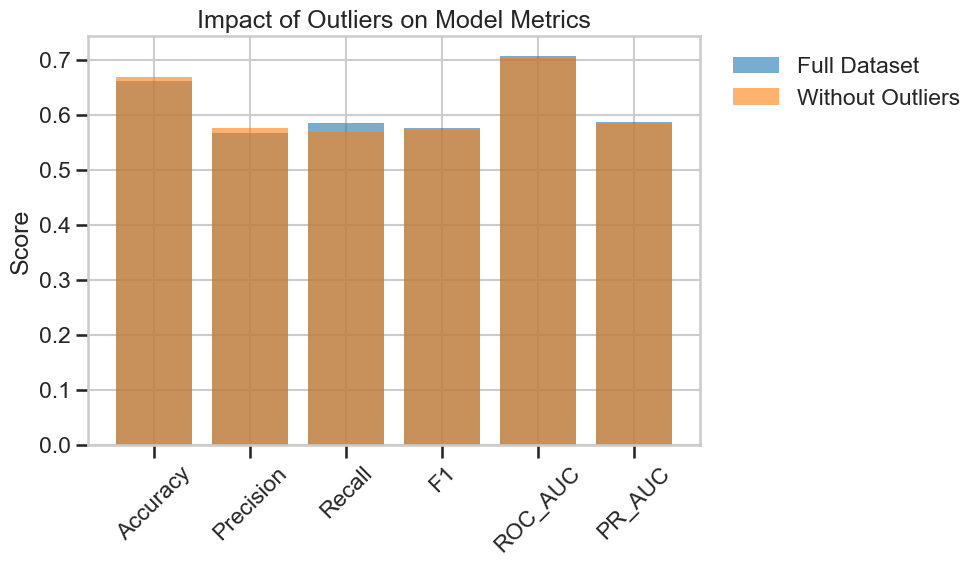

In [40]:
# ================================================
# Optional: Visual Comparison of Stress Test Results
# ================================================

import matplotlib.pyplot as plt

# Outlier impact
before = outlier_results["metrics_full"]
after = outlier_results["metrics_reduced"]

plt.figure(figsize=(12,6))
plt.bar(before.keys(), before.values(), alpha=0.6, label="Full Dataset")
plt.bar(after.keys(), after.values(), alpha=0.6, label="Without Outliers")
plt.xticks(rotation=45)
plt.ylabel("Score")
plt.title("Impact of Outliers on Model Metrics")

# Legend outside top-right, white background, no overlay
plt.legend(
    loc="upper left",
    bbox_to_anchor=(1.02, 1),   # move it just outside the plot
    facecolor="white",
    framealpha=1,
    edgecolor="black"
)

plt.tight_layout(rect=[0, 0, 0.85, 1])  # leave space on the right for legend
plt.show()
